In [37]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jax.scipy as jsci

# PATH HACKING
import pathlib
import sys
_path = str(pathlib.Path('..').resolve().absolute())
if _path not in sys.path:
    sys.path.insert(0, _path)
from gd1_helpers.truncnorm import logpdf as truncnorm_logpdf

import numpy as np
from scipy.stats import truncnorm

import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco

In [2]:
@jax.jit
def test(p, x):
    mu = p[0]
    std = p[1]
    a = (-2 - mu / std)
    b = (5 - mu / std)
    return truncnorm_logpdf(x, mu, std, a, b)

test([0.5, 3.], 1.)

DeviceArray(-2.01619326, dtype=float64)

In [3]:
gradfunc = jax.jit(jax.grad(test))

In [4]:
gradfunc([0.5, 3.], 1.)

[DeviceArray(0.04264377, dtype=float64),
 DeviceArray(-0.32192211, dtype=float64)]

In [22]:
@jax.jit
def two_truncnorm_mixture_ln_prob(p, data, data_err, lower, upper):
    w, mu1, mu2, ln_s1, ln_s2 = p 
    std1 = jnp.sqrt(jnp.exp(2 * ln_s1) + data_err**2)
    std2 = jnp.sqrt(std1**2 + jnp.exp(2 * ln_s2) + data_err**2)
    
    ln_term1 = truncnorm_logpdf(data, mu1, std1, (lower - mu1) / std1, (upper - mu1) / std1)
#     ln_term1 = truncnorm_logpdf(data, mu1, 1., (lower - mu1) / 1., (upper - mu1) / 1.)
    ln_term2 = truncnorm_logpdf(data, mu2, std2, (lower - mu2) / std2, (upper - mu2) / std2)
#     ln_term2 = 0.
    
    ln_prob = jnp.logaddexp(
        ln_term1 + jnp.log(w),
        ln_term2 + jnp.log(1 - w)
    )
    
    return ln_prob


@jax.jit
def objective(p, data, data_err):
    lower = -1e3
    upper = -1.
    return - two_truncnorm_mixture_ln_prob(p, data, data_err, lower, upper).sum() / len(data)


obj_gradfunc = jax.jit(jax.grad(objective))

In [23]:
x0 = jnp.array([0.65, 0.75, -4, np.log(3), np.log(4)])
data = np.linspace(-10, -5, 128)

objective(x0, data, 0.)

DeviceArray(3.25677027, dtype=float64)

In [24]:
# two_truncnorm_mixture_ln_prob(x0, data, 0., -np.inf, -1.)

In [25]:
obj_gradfunc(x0, data, 0.)

DeviceArray([ 1.84533721,  0.09229536,  0.04659901, -0.95563029,
              0.03282188], dtype=float64)

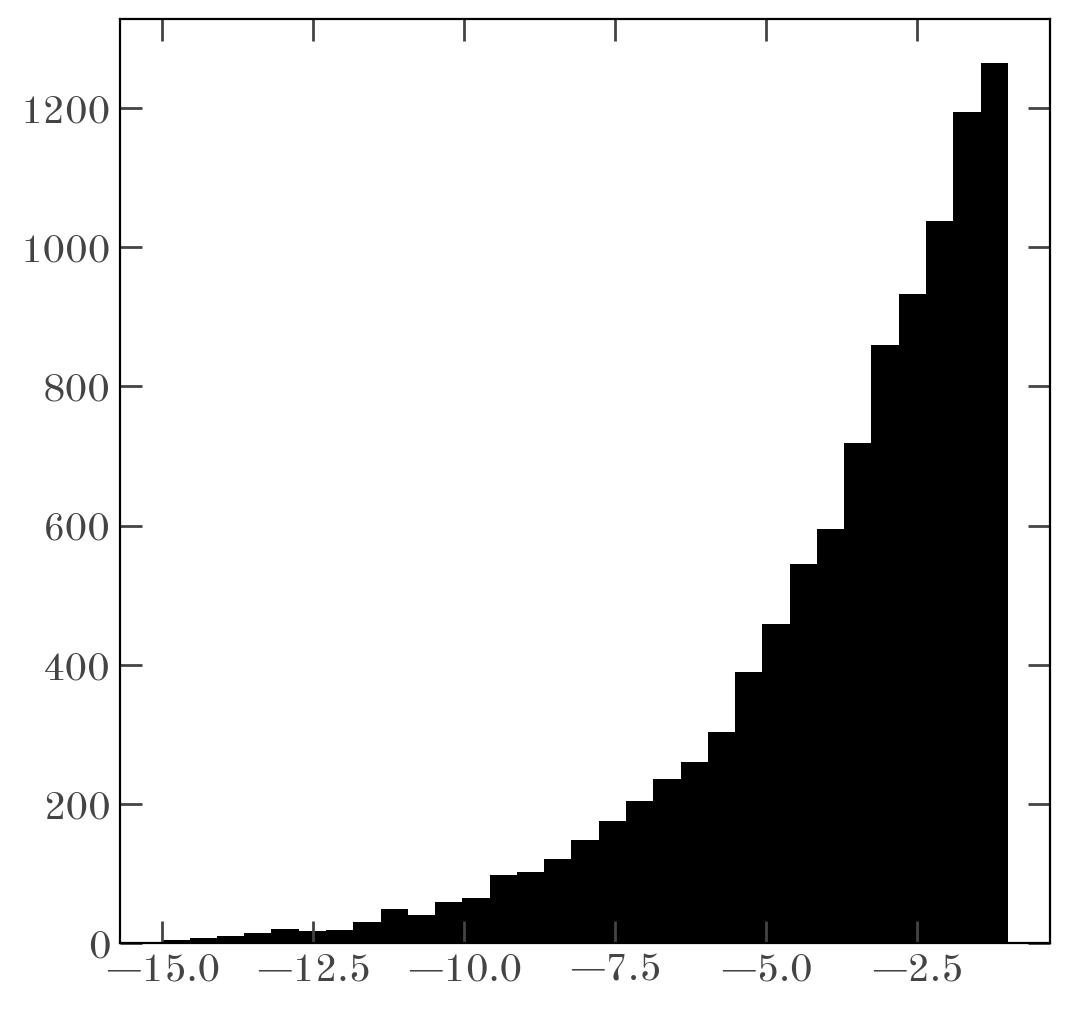

In [77]:
lower = -1e3
upper = -1
true_mu1 = 0.75
true_std1 = 3.
true_mu2 = -4.
true_std2 = 4.
w = 0.65
N = 10_000

samples1 = truncnorm.rvs(
    loc=true_mu1, scale=true_std1, 
    a=(lower - true_mu1) / true_std1, b=(upper - true_mu1) / true_std1,
    size=int(N * w)
)
samples2 = truncnorm.rvs(
    loc=true_mu2, scale=true_std2, 
    a=(lower - true_mu2) / true_std2, b=(upper - true_mu2) / true_std2,
    size=int(N * (1 - w))
)
samples = np.concatenate((samples1, samples2))

plt.hist(samples, bins=np.linspace(-15, -1, 32));

In [78]:
obj_grad = jax.jit(jax.grad(objective))

In [80]:
x0 = jnp.array([0.65, true_mu1, true_mu2, np.log(true_std1), np.log(true_std2)])

In [81]:
obj_grad(x0, samples, 0.)

DeviceArray([-0.08397559,  0.00203181, -0.00827847,  0.01605446,
              0.05285034], dtype=float64)

In [82]:
res = sco.minimize(
    objective, 
    x0=x0,
    jac=lambda x, *args: np.array(obj_grad(x, *args)),
    method='l-bfgs-b',
    bounds=[(0, 1), (-10, 10), (-10, 10), (-5, 5), (-5, 5)],
    args=(samples, 0.),
    options=dict(maxls=1000)
)
res

      fun: 2.0239469603571703
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.92096360e-05, -1.66878565e-05, -2.97104522e-05, -1.59345374e-05,
       -5.29502617e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 14
      nit: 13
     njev: 14
   status: 0
  success: True
        x: array([ 0.66067918,  0.73718649, -3.96198621,  1.11575011,  0.97884177])

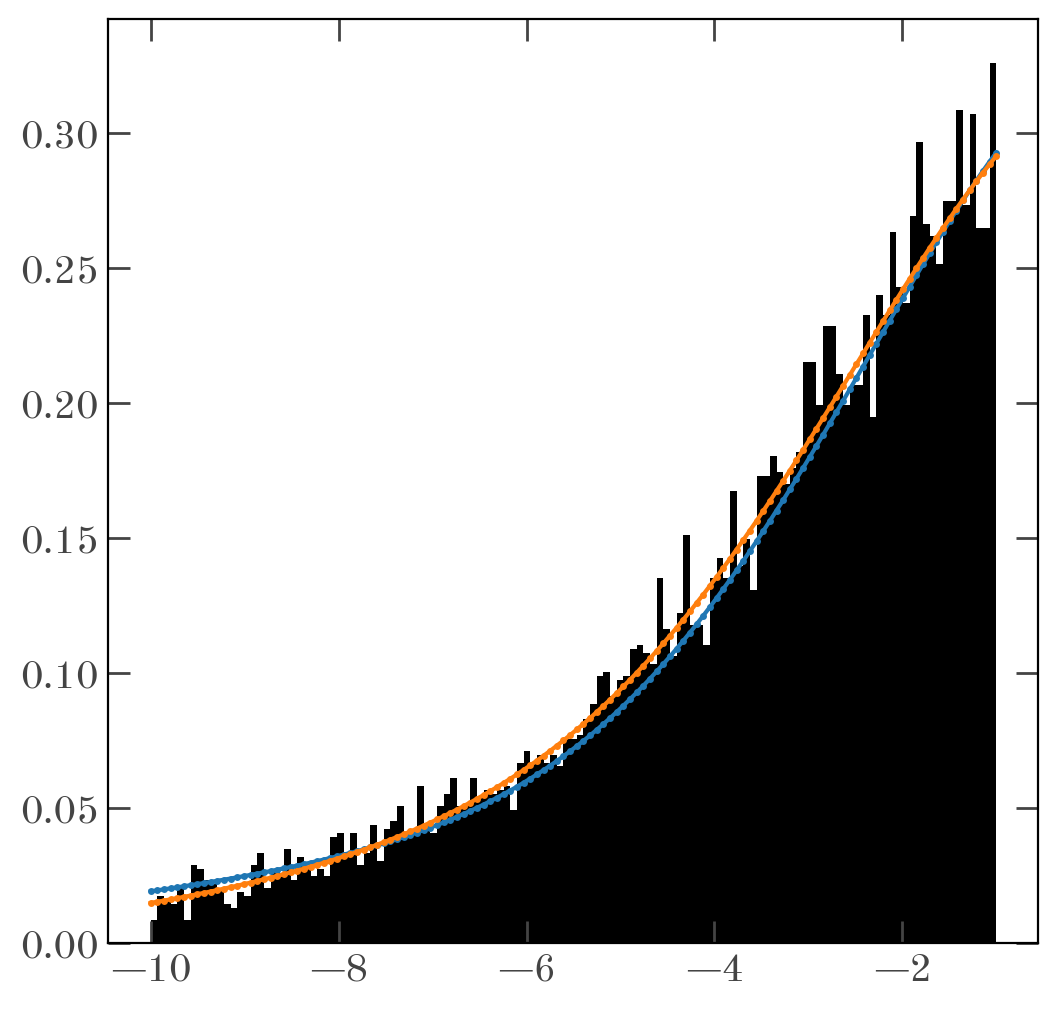

In [83]:
plt.hist(samples, bins=np.linspace(-10, -1, 128), density=True)

grid = np.linspace(-10, -1, 128)
plt.plot(grid, np.exp(two_truncnorm_mixture_ln_prob(x0, grid, 0., -1e3, -1)))
plt.plot(grid, np.exp(two_truncnorm_mixture_ln_prob(res.x, grid, 0., -1e3, -1)))